# Analyzing NYC High School data

## Read the data

In [1]:
%reset -f

import pandas as pd
import matplotlib.pyplot as plt
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

<AxesSubplot:>

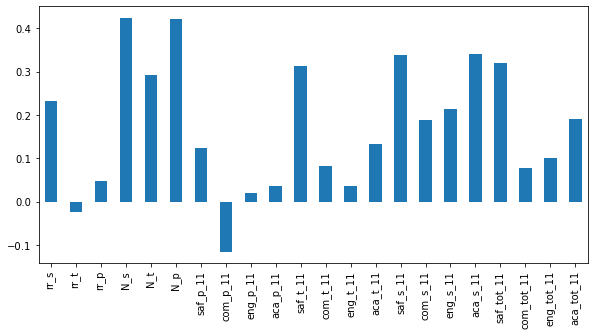

In [11]:
fig, ax = plt.subplots(figsize=(25*0.3937, 12*0.3937))
combined.corr()["sat_score"][survey_fields].plot.bar(ax=ax)

The number of student respondents (`N_s`), teacher respondents (`N_t`) and parent respondents (`N_p`) are moderately correlated with the SAT score.
The safety and respect score based on teacher and student responses (`saf_t_11` and `saf_s_11`) also has a moderate correlation with the SAT score. It makes sense students achieve more when they feel safe and respected.
Finally, academic expectations score based on student responses (`aca_s_11`) has a moderate correlation with the SAT score. However, the same does not apply for the academic expectations score based on teacher (`aca_t_11`) and parent responses (`aca_p_11`).

## Exploring Safety and SAT Scores

(4.0, 9.0)

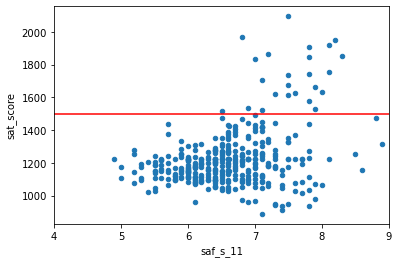

In [12]:
fig, ax = plt.subplots()
combined.plot.scatter(x='saf_s_11', y='sat_score', ax=ax);
xlim = ax.get_xlim()
ax.hlines(1500, 4, 9, colors='red')
ax.set_xlim(4, 9)

There isn’t any school with a safety score lower than 6.5 that has a SAT score higher than 1600, which evidences the importance of students feeling safe to be able to excel.

## Exploring Race and SAT Scores

<AxesSubplot:>

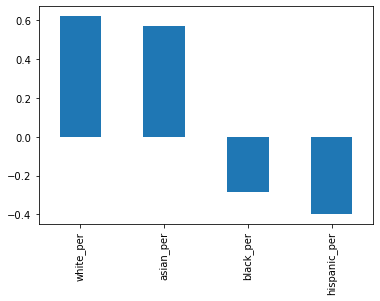

In [13]:
# Columns that indicate the percentage of each race at a given school
race_cols = ['white_per','asian_per','black_per','hispanic_per']

# Correlation between race_cols and sat_score
combined.corr()["sat_score"][race_cols].plot.bar()

The White and Asian races have a high positive correlation with SAT score. In contrast, the Black and Hispanic races have a moderate negative correlation with SAT score. This might indicate that the schools that most Black and Hispanic students attend have more unsatisfactory conditions.

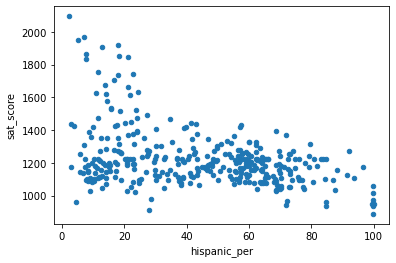

In [14]:
combined.plot.scatter(x='hispanic_per', y='sat_score');

In [15]:
# List the school names with more than 95% of Hispanic people
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [16]:
# List the percentage of English-language learners for the previous schools
combined[combined["hispanic_per"] > 95]["ell_percent"]

44     72.6
82     19.6
89     89.6
125    86.6
141    79.9
176    92.9
253    94.6
286    91.3
Name: ell_percent, dtype: float64

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which could explain the lower SAT scores.

In [17]:
# List the school names with less than 10% of Hispanic people and an average SAT score greater than 1800
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam.  This doesn't explain the low `hispanic_per`, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Exploring Gender and SAT Scores

<AxesSubplot:>

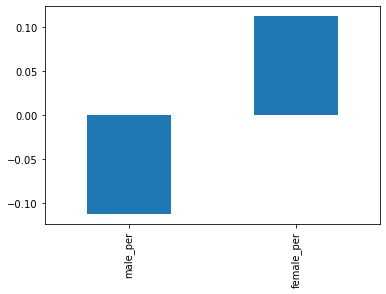

In [18]:
# Correlation between gender columns and SAT score
combined.corr()["sat_score"][['male_per','female_per']].plot.bar()

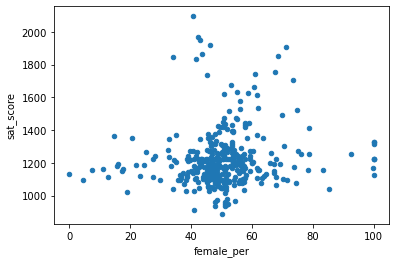

In [19]:
combined.plot.scatter(x='female_per', y='sat_score');

We can see that there is a low positive correlation between the percentage of females at a school and the SAT score. In contrast, there is a low negative correlation between the percentage of males at a school and the SAT score. There is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [20]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

It seems that these schools are very selective liberal arts schools that have high academic standards.

## Exploring AP Scores vs. SAT Scores

In [ ]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

There is a low to moderate positive correlation between the percentage of students in a school who take the AP exam and the SAT score.